In [2]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

DEUTSCH-JOZA ALGORITHM 


In [3]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

In [4]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [5]:
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

┌───┐     ┌─────────┐┌───┐┌─┐         
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├─────────
     ├───┤     │         │├───┤└╥┘┌─┐      
q_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├──────
     ├───┤     │         │├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├─────┤2 Oracle ├┤ H ├─╫──╫─┤M├───
     ├───┤     │         │├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─────┤3        ├┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├┤4        ├──────╫──╫──╫──╫─
     └───┘└───┘└─────────┘      ║  ║  ║  ║ 
c: 4/═══════════════════════════╩══╩══╩══╩═
                                0  1  2  3

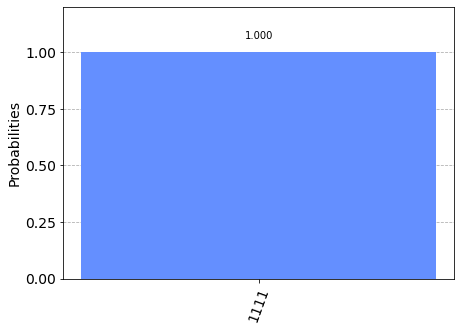

In [6]:
qasm_sim = Aer.get_backend('qasm_simulator')

transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

RUNNING ON REAL Q.COMPUTER

CREATE API ACCESS

In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
qobj = assemble(transpiled_dj_circuit, backend)
job = backend.run(qobj)
job_monitor(job, interval=2)

# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

BERNSTEIN-VAZIRANI ALGORITHM 

In [8]:
from qiskit_textbook.widgets import bv_widget
bv_widget(2, "11")

HTMLMath(value='$$ |00\\rangle = |00\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xce\x00\x00\x00\xcc\x08\x06\x00\x00\x00;\xd7\x9c…

In [9]:
# initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble

# import basic plot tools
from qiskit.visualization import plot_histogram

In [10]:
n = 3 # number of qubits used to represent s
s = '011'   # the hidden binary string

In [11]:
# We need a circuit with n qubits, plus one ancilla qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(n+1, n)

# put ancilla in state |->
bv_circuit.h(n)
bv_circuit.z(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)
    
# Apply barrier 
bv_circuit.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        bv_circuit.i(q)
    else:
        bv_circuit.cx(q, n)
        
# Apply barrier 
bv_circuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

bv_circuit.draw()

┌───┐      ░                 ░ ┌───┐┌─┐      
q_0: ┤ H ├──────░───■─────────────░─┤ H ├┤M├──────
     ├───┤      ░   │             ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├──────░───┼─────────■───░─┤ H ├─╫─┤M├───
     ├───┤      ░   │  ┌───┐  │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├──────░───┼──┤ I ├──┼───░─┤ H ├─╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐└───┘┌─┴─┐ ░ └───┘ ║  ║ └╥┘
q_3: ┤ H ├┤ Z ├─░─┤ X ├─────┤ X ├─░───────╫──╫──╫─
     └───┘└───┘ ░ └───┘     └───┘ ░       ║  ║  ║ 
c: 3/═════════════════════════════════════╩══╩══╩═
                                          0  1  2

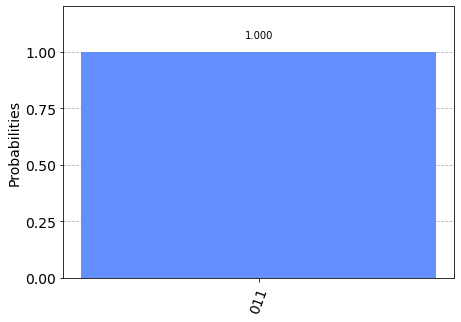

In [12]:
# use local simulator
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 1024
qobj = assemble(bv_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [ ]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
                                   x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_bv_circuit = transpile(bv_circuit, backend)
qobj = assemble(transpiled_bv_circuit, shots=shots)
job = backend.run(qobj)

job_monitor(job, interval=2)

# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

SIMONS ALGORITHM 

In [15]:
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile, assemble

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import simon_oracle

In [16]:
b = '110'

n = len(b)
simon_circuit = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit.h(range(n))    
    
# Apply barrier for visual separation
simon_circuit.barrier()

simon_circuit += simon_oracle(b)

# Apply barrier for visual separation
simon_circuit.barrier()

# Apply Hadamard gates to the input register
simon_circuit.h(range(n))

# Measure qubits
simon_circuit.measure(range(n), range(n))
simon_circuit.draw()

┌───┐ ░                           ░ ┌───┐┌─┐      
q_0: ┤ H ├─░───■───────────────────────░─┤ H ├┤M├──────
     ├───┤ ░   │                       ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├─░───┼────■─────────■────■───░─┤ H ├─╫─┤M├───
     ├───┤ ░   │    │         │    │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─░───┼────┼────■────┼────┼───░─┤ H ├─╫──╫─┤M├
     └───┘ ░ ┌─┴─┐  │    │    │    │   ░ └───┘ ║  ║ └╥┘
q_3: ──────░─┤ X ├──┼────┼────┼────┼───░───────╫──╫──╫─
           ░ └───┘┌─┴─┐  │  ┌─┴─┐  │   ░       ║  ║  ║ 
q_4: ──────░──────┤ X ├──┼──┤ X ├──┼───░───────╫──╫──╫─
           ░      └───┘┌─┴─┐└───┘┌─┴─┐ ░       ║  ║  ║ 
q_5: ──────░───────────┤ X ├─────┤ X ├─░───────╫──╫──╫─
           ░           └───┘     └───┘ ░       ║  ║  ║ 
c: 3/══════════════════════════════════════════╩══╩══╩═
                                               0  1  2

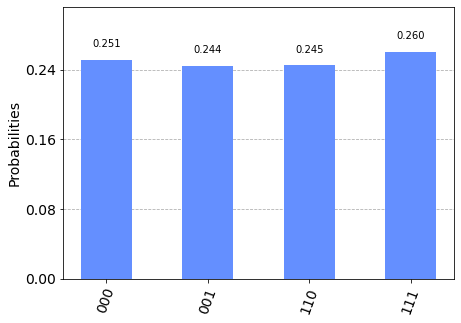

In [21]:
# use local simulator
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 1024
qobj = assemble(simon_circuit, shots=shots)
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [18]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(b, z, bdotz(b,z)) )

110.000 = 0 (mod 2)
110.001 = 0 (mod 2)
110.110 = 0 (mod 2)
110.111 = 0 (mod 2)


In [ ]:
#EXPERIMENT WITH REAL DEVICE

In [19]:
b = '11'
n = len(b)
simon_circuit_2 = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit_2.h(range(n))

# Query oracle
simon_circuit_2 += simon_oracle(b)

# Apply Hadamard gates to the input register
simon_circuit_2.h(range(n))

# Measure qubits
simon_circuit_2.measure(range(n), range(n))
simon_circuit_2.draw()

┌───┐                         ┌───┐┌─┐
q_0: ┤ H ├──■─────────■─────────■──┤ H ├┤M├
     ├───┤  │         │  ┌───┐  │  └┬─┬┘└╥┘
q_1: ┤ H ├──┼────■────┼──┤ H ├──┼───┤M├──╫─
     └───┘┌─┴─┐  │  ┌─┴─┐└───┘  │   └╥┘  ║ 
q_2: ─────┤ X ├──┼──┤ X ├───────┼────╫───╫─
          └───┘┌─┴─┐└───┘     ┌─┴─┐  ║   ║ 
q_3: ──────────┤ X ├──────────┤ X ├──╫───╫─
               └───┘          └───┘  ║   ║ 
c: 2/════════════════════════════════╩═══╩═
                                     1   0

In [ ]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Execute and monitor the job
from qiskit.tools.monitor import job_monitor
shots = 1024
transpiled_simon_circuit = transpile(simon_circuit, backend, optimization_level=3)
qobj = assemble(transpiled_simon_circuit, shots=shots)
job = backend.run(qobj)
job_monitor(job, interval=2)

In [ ]:
# Get results and plot counts
device_counts = job.result().get_counts()
plot_histogram(device_counts)

In [ ]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

print('b = ' + b)
for z in device_counts:
    print( '{}.{} = {} (mod 2) ({:.1f}%)'.format(b, z, bdotz(b,z), device_counts[z]*100/shots))

QUANTUM FOURIER TRANSFORM

In [22]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [25]:
qc = QuantumCircuit(3)

qc.h(2)

qc.cp(pi/2, 1, 2) # CROT from qubit 1 to qubit 2

qc.cp(pi/4, 0, 2) # CROT from qubit 2 to qubit 0
qc.draw()

q_0: ───────────────────■─────
                        │     
q_1: ─────────■─────────┼─────
     ┌───┐┌───┴────┐┌───┴────┐
q_2: ┤ H ├┤ P(π/2) ├┤ P(π/4) ├
     └───┘└────────┘└────────┘

In [26]:
qc.h(1)
qc.cp(pi/2, 0, 1) # CROT from qubit 0 to qubit 1
qc.h(0)
qc.draw()

┌───┐
q_0: ───────────────────■──────────────■─────┤ H ├
                        │     ┌───┐┌───┴────┐└───┘
q_1: ─────────■─────────┼─────┤ H ├┤ P(π/2) ├─────
     ┌───┐┌───┴────┐┌───┴────┐└───┘└────────┘     
q_2: ┤ H ├┤ P(π/2) ├┤ P(π/4) ├────────────────────
     └───┘└────────┘└────────┘

In [27]:
qc.swap(0,2)
qc.draw()

┌───┐   
q_0: ───────────────────■──────────────■─────┤ H ├─X─
                        │     ┌───┐┌───┴────┐└───┘ │ 
q_1: ─────────■─────────┼─────┤ H ├┤ P(π/2) ├──────┼─
     ┌───┐┌───┴────┐┌───┴────┐└───┘└────────┘      │ 
q_2: ┤ H ├┤ P(π/2) ├┤ P(π/4) ├─────────────────────X─
     └───┘└────────┘└────────┘

In [28]:
def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cp(pi/2**(n-qubit), qubit, n)

In [29]:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw()

q_0: ─────────■─────────────────────────
              │                         
q_1: ─────────┼─────────■───────────────
              │         │               
q_2: ─────────┼─────────┼─────────■─────
     ┌───┐┌───┴────┐┌───┴────┐┌───┴────┐
q_3: ┤ H ├┤ P(π/8) ├┤ P(π/4) ├┤ P(π/2) ├
     └───┘└────────┘└────────┘└────────┘

In [30]:
from qiskit_textbook.widgets import scalable_circuit
scalable_circuit(qft_rotations)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01G\x00\x00\x01\x08\x08\x06\x00\x00\x00\xccG6\xd2\x…

In [35]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

# Let's see how it looks:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw()

»
q_0: ─────────■──────────────────────────────────■────────────────────»
              │                                  │               ┌───┐»
q_1: ─────────┼─────────■────────────────────────┼─────────■─────┤ H ├»
              │         │               ┌───┐┌───┴────┐┌───┴────┐└───┘»
q_2: ─────────┼─────────┼─────────■─────┤ H ├┤ P(π/4) ├┤ P(π/2) ├─────»
     ┌───┐┌───┴────┐┌───┴────┐┌───┴────┐└───┘└────────┘└────────┘     »
q_3: ┤ H ├┤ P(π/8) ├┤ P(π/4) ├┤ P(π/2) ├──────────────────────────────»
     └───┘└────────┘└────────┘└────────┘                              »
«               ┌───┐
«q_0: ────■─────┤ H ├
«     ┌───┴────┐└───┘
«q_1: ┤ P(π/2) ├─────
«     └────────┘     
«q_2: ───────────────
«                    
«q_3: ───────────────
«

In [39]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw()

»
q_0: ─────────■──────────────────────────────────■────────────────────»
              │                                  │               ┌───┐»
q_1: ─────────┼─────────■────────────────────────┼─────────■─────┤ H ├»
              │         │               ┌───┐┌───┴────┐┌───┴────┐└───┘»
q_2: ─────────┼─────────┼─────────■─────┤ H ├┤ P(π/4) ├┤ P(π/2) ├─────»
     ┌───┐┌───┴────┐┌───┴────┐┌───┴────┐└───┘└────────┘└────────┘     »
q_3: ┤ H ├┤ P(π/8) ├┤ P(π/4) ├┤ P(π/2) ├──────────────────────────────»
     └───┘└────────┘└────────┘└────────┘                              »
«               ┌───┐   
«q_0: ────■─────┤ H ├─X─
«     ┌───┴────┐└───┘ │ 
«q_1: ┤ P(π/2) ├──X───┼─
«     └────────┘  │   │ 
«q_2: ────────────X───┼─
«                     │ 
«q_3: ────────────────X─
«

In [42]:
scalable_circuit(qft)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\xec\x00\x00\x01\x08\x08\x06\x00\x00\x00\x04\x1d\…

In [41]:
bin(5)

'0b101'

In [43]:
# Create the circuit
qc = QuantumCircuit(3)

# Encode the state 5
qc.x(0)
qc.x(2)
qc.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘

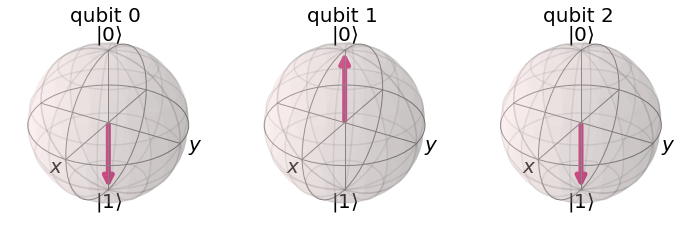

In [44]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

In [45]:
qft(qc,3)
qc.draw()

┌───┐                                        ┌───┐   
q_0: ┤ X ├─────────■────────────────────────■─────┤ H ├─X─
     └───┘         │               ┌───┐┌───┴────┐└───┘ │ 
q_1: ──────────────┼─────────■─────┤ H ├┤ P(π/2) ├──────┼─
     ┌───┐┌───┐┌───┴────┐┌───┴────┐└───┘└────────┘      │ 
q_2: ┤ X ├┤ H ├┤ P(π/4) ├┤ P(π/2) ├─────────────────────X─
     └───┘└───┘└────────┘└────────┘

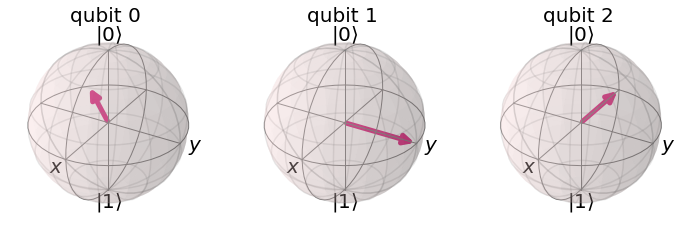

In [46]:
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

In [ ]:
"""
We can see out QFT function has worked correctly. Compared the the state |˜0⟩=|+++⟩, Qubit 0 has been rotated by 5/8 of a full turn, qubit 1 by 10/8full turns (equivalent to 1/4 of a full turn), and qubit 2 by 20/8 full turns (equivalent to 1/2 of a full turn).

"""

QFT ON A REAL QUANTUM DEVICE -CREATE API


QUANTUM PHASE ESTIMATION

In [47]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram

In [ ]:
#example for theta= 1/8 (t gate)

In [48]:
qpe = QuantumCircuit(4, 3)
qpe.x(3)
qpe.draw()

q_0: ─────
          
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
c: 3/═════

In [49]:
for qubit in range(3):
    qpe.h(qubit)
qpe.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ X ├
     └───┘
c: 3/═════

In [50]:
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(math.pi/4, counting_qubit, 3); # This is C-U
    repetitions *= 2
qpe.draw()

┌───┐                                                            »
q_0: ┤ H ├────■───────────────────────────────────────────────────────»
     ├───┤    │                                                       »
q_1: ┤ H ├────┼─────────■─────────■───────────────────────────────────»
     ├───┤    │         │         │                                   »
q_2: ┤ H ├────┼─────────┼─────────┼─────────■─────────■─────────■─────»
     ├───┤┌───┴────┐┌───┴────┐┌───┴────┐┌───┴────┐┌───┴────┐┌───┴────┐»
q_3: ┤ X ├┤ P(π/4) ├┤ P(π/4) ├┤ P(π/4) ├┤ P(π/4) ├┤ P(π/4) ├┤ P(π/4) ├»
     └───┘└────────┘└────────┘└────────┘└────────┘└────────┘└────────┘»
c: 3/═════════════════════════════════════════════════════════════════»
                                                                      »
«               
«q_0: ──────────
«               
«q_1: ──────────
«               
«q_2: ────■─────
«     ┌───┴────┐
«q_3: ┤ P(π/4) ├
«     └────────┘
«c: 3/══════════
«

In [51]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [52]:
qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, 3)
# Measure
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)

In [53]:
qpe.draw()

┌───┐                                                            »
q_0: ┤ H ├────■───────────────────────────────────────────────────────»
     ├───┤    │                                                       »
q_1: ┤ H ├────┼─────────■─────────■───────────────────────────────────»
     ├───┤    │         │         │                                   »
q_2: ┤ H ├────┼─────────┼─────────┼─────────■─────────■─────────■─────»
     ├───┤┌───┴────┐┌───┴────┐┌───┴────┐┌───┴────┐┌───┴────┐┌───┴────┐»
q_3: ┤ X ├┤ P(π/4) ├┤ P(π/4) ├┤ P(π/4) ├┤ P(π/4) ├┤ P(π/4) ├┤ P(π/4) ├»
     └───┘└────────┘└────────┘└────────┘└────────┘└────────┘└────────┘»
c: 3/═════════════════════════════════════════════════════════════════»
                                                                      »
«                ░    ┌───┐                                            ░ ┌─┐   »
«q_0: ───────────░──X─┤ H ├─────■───────────────■──────────────────────░─┤M├───»
«                ░  │ └───┘┌────┴────┐┌───┐     │                      ░ └╥┘┌─┐»
«q_1: ───────────░──┼──────┤ P(-π/2) ├┤ H ├─────┼──────────■───────────░──╫─┤M├»
«                ░  │      └─────────┘└───┘┌────┴────┐┌────┴────┐┌───┐ ░  ║ └╥┘»
«q_2: ────■──────░──X──────────────────────┤ P(-π/4) ├┤ P(-π/2) ├┤ H ├─░──╫──╫─»
«     ┌───┴────┐ ░                         └─────────┘└─────────┘└───┘ ░  ║  ║ »
«q_3: ┤ P(π/4) ├─░─────────────────────────────────────────────────────░──╫──╫─»
«     └────────┘ ░                                                     ░  ║  ║ »
«c: 3/════════════════════════════════════════════════════════════════════╩══╩═»
«                                                                         0  1 »
«        
«q_0: ───
«        
«q_1: ───
«     ┌─┐
«q_2: ┤M├
«     └╥┘
«q_3: ─╫─
«      ║ 
«c: 3/═╩═
«      2

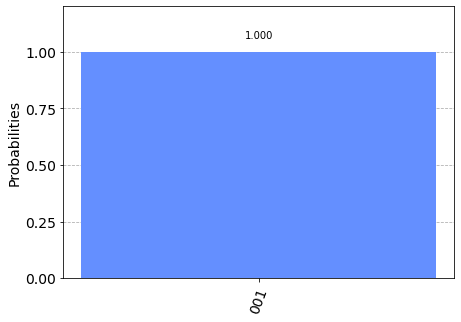

In [54]:
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 2048
t_qpe = transpile(qpe, qasm_sim)
qobj = assemble(t_qpe, shots=shots)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [ ]:
"""
001=1 SO 1/2^3= 1/8 as expected.
"""

In [ ]:
#example for theta= 1/3

In [55]:
# Create and set up circuit
qpe2 = QuantumCircuit(4, 3)

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe2.h(qubit)

# Prepare our eigenstate |psi>:
qpe2.x(3)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe2.cp(angle, counting_qubit, 3);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe2, 3)

# Measure of course!
for n in range(3):
    qpe2.measure(n,n)

qpe2.draw()

┌───┐                                                                  »
q_0: ┤ H ├─────■────────────────────────────────────────────────────────────»
     ├───┤     │                                                            »
q_1: ┤ H ├─────┼──────────■──────────■──────────────────────────────────────»
     ├───┤     │          │          │                                      »
q_2: ┤ H ├─────┼──────────┼──────────┼──────────■──────────■──────────■─────»
     ├───┤┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐»
q_3: ┤ X ├┤ P(2π/3) ├┤ P(2π/3) ├┤ P(2π/3) ├┤ P(2π/3) ├┤ P(2π/3) ├┤ P(2π/3) ├»
     └───┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
c: 3/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                   ┌───┐                                      ┌─┐           
«q_0: ────────────X─┤ H ├─────■───────────────■────────────────┤M├───────────
«                 │ └───┘┌────┴────┐┌───┐     │                └╥┘     ┌─┐   
«q_1: ────────────┼──────┤ P(-π/2) ├┤ H ├─────┼──────────■──────╫──────┤M├───
«                 │      └─────────┘└───┘┌────┴────┐┌────┴────┐ ║ ┌───┐└╥┘┌─┐
«q_2: ─────■──────X──────────────────────┤ P(-π/4) ├┤ P(-π/2) ├─╫─┤ H ├─╫─┤M├
«     ┌────┴────┐                        └─────────┘└─────────┘ ║ └───┘ ║ └╥┘
«q_3: ┤ P(2π/3) ├───────────────────────────────────────────────╫───────╫──╫─
«     └─────────┘                                               ║       ║  ║ 
«c: 3/══════════════════════════════════════════════════════════╩═══════╩══╩═
«                                                               0       1  2

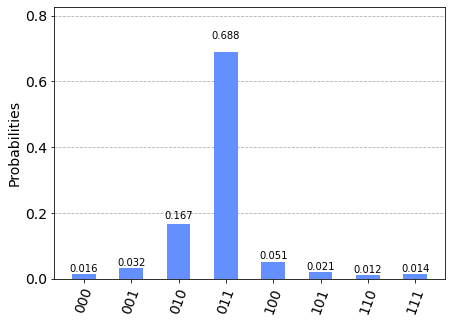

In [56]:
# Let's see the results!
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 4096
t_qpe2 = transpile(qpe2, qasm_sim)
qobj = assemble(t_qpe2, shots=shots)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [ ]:
"""
We are expecting the result θ=0.3333…, and we see our most likely results are 010(bin) = 2(dec) and 011(bin) = 3(dec). These two results would tell us that  θ=0.25 (off by 25%) and  θ=0.375 (off by 13%) respectively.

The true value of θ lies between the values we can get from our counting bits, and this gives us uncertainty and imprecision.

To get more precision we simply add more counting qubits. We are going to add two more counting qubits:

"""

In [57]:
# Create and set up circuit
qpe3 = QuantumCircuit(6, 5)

# Apply H-Gates to counting qubits:
for qubit in range(5):
    qpe3.h(qubit)

# Prepare our eigenstate |psi>:
qpe3.x(5)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe3.cp(angle, counting_qubit, 5);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe3, 5)

# Measure of course!
qpe3.barrier()
for n in range(5):
    qpe3.measure(n,n)

qpe3.draw()

┌───┐                                                                  »
q_0: ┤ H ├─────■────────────────────────────────────────────────────────────»
     ├───┤     │                                                            »
q_1: ┤ H ├─────┼──────────■──────────■──────────────────────────────────────»
     ├───┤     │          │          │                                      »
q_2: ┤ H ├─────┼──────────┼──────────┼──────────■──────────■──────────■─────»
     ├───┤     │          │          │          │          │          │     »
q_3: ┤ H ├─────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────»
     ├───┤     │          │          │          │          │          │     »
q_4: ┤ H ├─────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────»
     ├───┤┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐»
q_5: ┤ X ├┤ P(2π/3) ├┤ P(2π/3) ├┤ P(2π/3) ├┤ P(2π/3) ├┤ P(2π/3) ├┤ P(2π/3) ├»
     └───┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
c: 5/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                       »
«q_0: ──────────────────────────────────────────────────────────────────»
«                                                                       »
«q_1: ──────────────────────────────────────────────────────────────────»
«                                                                       »
«q_2: ─────■────────────────────────────────────────────────────────────»
«          │                                                            »
«q_3: ─────┼──────────■──────────■──────────■──────────■──────────■─────»
«          │          │          │          │          │          │     »
«q_4: ─────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────»
«     ┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐»
«q_5: ┤ P(2π/3) ├┤ P(2π/3) ├┤ P(2π/3) ├┤ P(2π/3) ├┤ P(2π/3) ├┤ P(2π/3) ├»
«     └─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
«c: 5/══════════════════════════════════════════════════════════════════»
«                                                                       »
«                                                                       »
«q_0: ──────────────────────────────────────────────────────────────────»
«                                                                       »
«q_1: ──────────────────────────────────────X───────────────────────────»
«                                           │                           »
«q_2: ──────────────────────────────────────┼───────────────────────────»
«                                           │                           »
«q_3: ─────■──────────■──────────■──────────X───────────────────────────»
«          │          │          │                                      »
«q_4: ─────┼──────────┼──────────┼──────────■──────────■──────────■─────»
«     ┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐»
«q_5: ┤ P(2π/3) ├┤ P(2π/3) ├┤ P(2π/3) ├┤ P(2π/3) ├┤ P(2π/3) ├┤ P(2π/3) ├»
«     └─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
«c: 5/══════════════════════════════════════════════════════════════════»
«                                                                       »
«                                                                       »
«q_0: ──────────────────────────────────────────────────────────────────»
«                                                                       »
«q_1: ──────────────────────────────────────────────────────────────────»
«                                                                       »
«q_2: ──────────────────────────────────────────────────────────────────»
«                                                                       »
«q_3: ──────────────────────────────────────────────────────────────────»
«                      

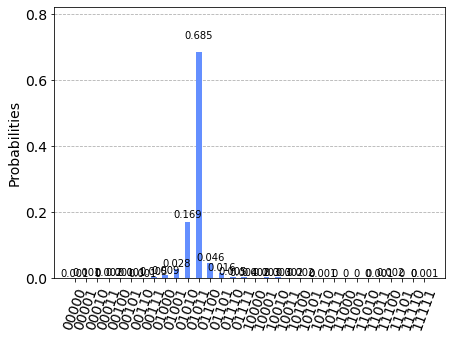

In [58]:
# Let's see the results!
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 4096
t_qpe3 = transpile(qpe3, qasm_sim)
qobj = assemble(t_qpe3, shots=shots)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [ ]:
""""
01011= 11

11/ 2^5= 0.034375 (error by 3%)

or 

01010 (decimal 10) with 0.313 (error by 6%)
""""

SHORS ALGORITHM 

WE START WITH PERIOD FINDING PROBLEM

N= 15, a= 7

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


In [61]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [93]:
# Specify variables
n_count = 8  # number of counting qubits
a = 13

In [94]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [95]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialise counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And ancilla register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(fold=-1)  # -1 means 'do not fold' 

┌───┐                                                                                                                                     ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                             │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼───────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │               │                                                                                                             │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼───────────────┼───────────────■─────────────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │               │               │                                                                                             │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼───────────────┼───────────────┼───────────────■─────────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │               │               │               │                                                                             │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────────────■────────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │               │               │               │                │                                                            │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────────────┼────────────────■───────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │               │               │               │                │                │                                           │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────────────┼────────────────┼────────────────■──────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │               │               │               │                │                │                │                          │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────────────┼────────────────┼────────────────┼────────────────■─────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      └───┘┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐┌───────┴────────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ─────┤0             ├┤0             ├┤0             ├┤0             ├┤0              ├┤0              ├┤0              ├┤0               ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │              ││              ││              ││              ││               ││               ││               ││                │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1             ├┤1             ├┤1             ├┤1             ├┤1              ├┤1              ├┤1              ├┤1               ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  13^1 mod 15 ││  13^2 mod 15 ││  13^4 mod 15 ││  13^8 mod 15 ││  13^16 mod 15 ││  13^32 mod 15 ││  13^64 mod 15 ││  13^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2             ├┤2             ├┤2             ├┤2             ├┤2              ├┤2              ├┤2              ├┤2               ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      ┌───┐│              ││              ││              ││              ││              

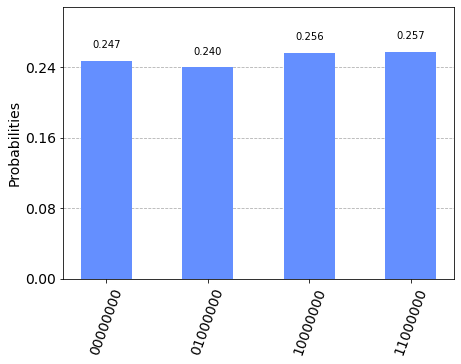

In [96]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [97]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


In [98]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

In [99]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.50      1/2            2
3   0.75      3/4            4


GROVERS ALGORITHM 

In [100]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

In [101]:
n = 2
grover_circuit = QuantumCircuit(n)

In [102]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [103]:
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

In [104]:
grover_circuit.cz(0,1) # Oracle
grover_circuit.draw()

┌───┐   
q_0: ┤ H ├─■─
     ├───┤ │ 
q_1: ┤ H ├─■─
     └───┘

In [105]:
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw()

┌───┐   ┌───┐┌───┐   ┌───┐
q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     ├───┤ │ ├───┤├───┤ │ ├───┤
q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     └───┘   └───┘└───┘   └───┘

In [106]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(grover_circuit)
result = sv_sim.run(qobj).result()
statevec = result.get_statevector()
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

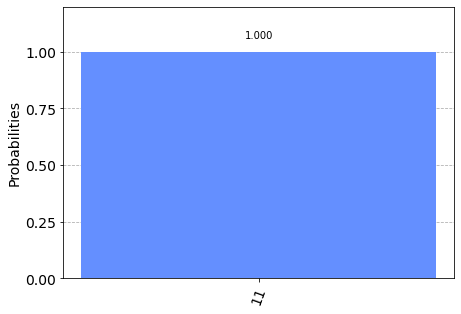

In [107]:
grover_circuit.measure_all()

qasm_sim = Aer.get_backend('qasm_simulator')
qobj = assemble(grover_circuit)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)